In [6]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

# Methods

- We will build models reflecting three levels of available data
    - "Easy" is mostly data already available to the emergency dispatcher before the notification comes in, like month, day of week, hour, weather, urban/rural, 

# Setup

## Import Libraries

In [7]:
print ('Install Packages')

import sys, copy, math, time, os

print ('Python version: {}'.format(sys.version))

#from collections import Counter

import numpy as np
print ('NumPy version: {}'.format(np.__version__))
np.set_printoptions(suppress=True)

import scipy as sc
print ('SciPy version:  {}'.format(sc.__version__))

import tensorflow as tf
print ('TensorFlow version:  {}'.format(tf.__version__))
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

from tensorflow import keras
print ('Keras version:  {}'.format(keras.__version__))

from keras import layers
import keras.backend as K
#from keras.layers import IntegerLookup
#from keras.layers import Normalization
#from keras.layers import StringLookup
#from keras.utils import get_custom_objects
#from keras.utils import tf_utils

from keras.models import Sequential
from keras.layers import Dense

#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

import pandas as pd
print ('Pandas version:  {}'.format(pd.__version__))
pd.set_option('display.max_rows', 500)

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 11,
})

import matplotlib.pyplot as plt
%matplotlib inline

# Library for reading Microsoft Access files
#import pandas_access as mdb

import sklearn
print ('SciKit-Learn version: {}'.format(sklearn.__version__))
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
#from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import imblearn
print ('Imbalanced-Learn version: {}'.format(imblearn.__version__))
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier

#!pip install pydot

# Set Randomness.  Copied from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
import random
#np.random.seed(42) # NumPy
#random.seed(42) # Python
#tf.random.set_seed(42) # Tensorflow

import warnings
warnings.filterwarnings('ignore')

print ('Finished Installing Packages')

Install Packages
Python version: 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
NumPy version: 1.24.2
SciPy version:  1.7.3
TensorFlow version:  2.11.0
Keras version:  2.11.0
Pandas version:  1.5.3
SciKit-Learn version: 1.2.2
Imbalanced-Learn version: 0.10.1
Finished Installing Packages


In [ ]:
def Chart_and_Plots(y_test, y_proba, y_pred, filename, run, title):
    print ('Charts_and_Plots() for ', filename)
    
    Analyze_Prediction(y_test, y_proba, filename, run, title)
    
    Plot_Prediction(y_test, y_proba, filename, run, title)
    Plot_Prediction_Wide(y_test, y_proba, filename, run, title)
#    print ("type(y_proba): ", type(y_proba))
    left = min(y_proba)
    right = max(y_proba)
#    print (left, right)
    Plot_Prediction_Zoom(y_test, y_proba, filename, run, title, left, right)
    Plot_Prediction_Zoom_Legend_Top(y_test, y_proba, filename, run, title, left, right)
    Plot_Prediction_Zoom_Medium(y_test, y_proba, filename, run, title, left, right)
    Plot_Prediction_Zoom_Wide(y_test, y_proba, filename, run, title, left, right)
    Plot_Prediction_Zoom_Wide_Right(y_test, y_proba, filename, run, title, left, right)
    
    

    ROC(y_test, y_proba, [], filename, run)
    ROC_Legend_Top(y_test, y_proba, [], filename, run)
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename, run)
    
#    print ()
    

In [ ]:
def Evaluate_Model(y_test, y_proba, y_pred, center, filename, run):
    print ('Evaluate_Model() for ', filename)
    y_test = np.array(y_test)
    y_pred = [round(x) for x in y_proba]
    y_pred = np.array(y_pred)
#    print ('np.unique(y_proba) = ', np.unique(y_proba))
#    print ('np.unique(y_pred) = ', np.unique(y_pred))
    CM = confusion_matrix(y_test, y_pred)
#    print(CM)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_value = auc(fpr, tpr)
    f = open('./Analyze_Proba/' + run + '/ROC_AUC.csv', 'a')
    f.write('%s,%f\n' % (filename, auc_value))
    f.close()
    
    CSV = [[filename, CM[0][0], CM[0][1], CM[1][0], CM[1][1], center, auc_value]]
    np.savetxt('./Confusion_Matrices/' + filename + '.csv', 
        CSV,
        delimiter =", ", 
        fmt ='% s'
              )
#    print ()
    CM = confusion_matrix(y_test, y_pred, normalize='all')
#    print(CM)
#    print ()

#    y_pred = y_pred.ravel()
#    y_test = tf.convert_to_tensor(y_test)
#    y_pred = tf.convert_to_tensor(y_pred)

#    print ('%.3f & Precision \cr ' %  Precision_Metric(y_test, y_pred).numpy())
#    print ('%.3f & Recall \cr ' %  Recall_Metric(y_test, y_pred).numpy())
#    print ('%.3f & F1 \cr ' %  F1_Metric(y_test, y_pred).numpy())



# Plots and Tables

## Plot Prediction

How to insert a .pgf plot into a \LaTeX document:

\begin{figure}
    \begin{center}
        \input{Plot.pgf}
    \end{center}
    \caption{A PGF histogram from \texttt{matplotlib}.}
\end{figure}


In [ ]:
def Plot_Prediction(y_test, y_proba, filename, run, title):
    print ('Plot_Prediction() for ', filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [x/n for x in range (0, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)
    
    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    plt.xticks(
        ticks = [0, 2.5, 5, 7.5, 10], 
        labels = ['0.0', '0.25', '0.5', '0.75', '1.0'],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
#    plt.tight_layout()
    plt.savefig('./Images/' + run + '/' + filename + '_Pred.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_Pred.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred.png')
#    plt.show()
    plt.close()
#    print ()
    return 0


In [ ]:
def Plot_Prediction_Zoom(y_test, y_proba, filename, run, title, left, right):
    print ('Plot_Prediction_Zoom() for ', filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

    ticks = [0, 5, 10]
    num_prec = int(-(math.log10((right-left)/2)))+2
    num_prec = max(num_prec,2)
    
    if num_prec==2:
        labels = ["{:.2f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    
    
#    labels = [str(round(left + (right-left) * t/10,3)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred_Zoom.png')
#    plt.show()
    plt.close()
#    print ()
    return 0


In [ ]:
def Plot_Prediction_Zoom_Legend_Top(y_test, y_proba, filename, run, title, left, right):
    print ('Plot_Prediction_Zoom() for ', filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.2,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

    ticks = [0, 5, 10]
    num_prec = int(-(math.log10((right-left)/2)))+2
    num_prec = max(num_prec,2)
    
    if num_prec==2:
        labels = ["{:.2f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    
    
#    labels = [str(round(left + (right-left) * t/10,3)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    ax.legend(['Neg', 'Pos'], loc='upper center', bbox_to_anchor=(0.5, 1.40), ncol=2)
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Legend_Top.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Legend_Top.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred_Zoom.png')
#    plt.show()
    plt.close()
#    print ()
    return 0


In [ ]:
def Plot_Prediction_Zoom_Medium(y_test, y_proba, filename, run, title, left, right):
    print ('Plot_Prediction_Zoom() for ', filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 20
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(3.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

    ticks = [0, 5, 10, 15, 20]
    num_prec = int(-(math.log10((right-left)/2)))+2
    num_prec = max(num_prec,2)
    
    if num_prec==2:
        labels = ["{:.2f}".format(round(left + (right-left) * t/n,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/n,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/n,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/n,num_prec)) for t in ticks]
    
    
#    labels = [str(round(left + (right-left) * t/10,3)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Medium.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Medium.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred_Zoom.png')
#    plt.show()
    plt.close()
#    print ()
    return 0


In [ ]:
def Plot_Prediction_Zoom_Wide(y_test, y_proba, filename, run, title, left, right):
    print ('Plot_Prediction_Zoom_Wide() for ', filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 20
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(4.5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

#    ticks = [0, 2.5, 5, 7.5, 10]
    ticks = [0, 4, 8, 12, 16, 20]
    num_prec = int(-(math.log10((right-left)/4)))+2
    num_prec = max(num_prec,2)
#    print ("left, right, (right-left)/5, -(math.log10((right-left)/5)), num_prec")
#    print (left, right, (right-left)/5, -(math.log10((right-left)/5)), num_prec)
    
    if num_prec<3:
        labels = ["{:.2f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
#    labels = [str(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    
    
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Wide.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Wide.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred_Zoom_Wide.png')
#    plt.show()
    plt.close()
#    print ()
    return 0


In [ ]:
def Plot_Prediction_Zoom_Wide_Right(y_test, y_proba, filename, run, title, left, right):
    print ('Plot_Prediction_Zoom_Wide_Right() for ', filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()

    left = (left + right)/2

    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 20
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(4.5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

#    ticks = [0, 2.5, 5, 7.5, 10]
    ticks = [0, 4, 8, 12, 16, 20]
    num_prec = int(-(math.log10((right-left)/4)))+2
    num_prec = max(num_prec,2)
#    print ("left, right, (right-left)/5, -(math.log10((right-left)/5)), num_prec")
#    print (left, right, (right-left)/5, -(math.log10((right-left)/5)), num_prec)
    
    if num_prec<3:
        labels = ["{:.2f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
#    labels = [str(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    
    
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Wide_Right.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Zoom_Wide_Right.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred_Zoom_Wide.png')
#    plt.show()
    plt.close()
#    print ()
    return 0


In [ ]:
def Plot_Prediction_Wide(y_test, y_proba, filename, run, title):
    print ('Plot_Prediction_Wide() for ', filename)
    
#    print ('y_test = ', y_test)
#    print ('y_proba = ',y_proba)

#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    print ("A = pd.DataFrame(y_proba, columns=['HOSPITAL'])")
#    display(A)
#    print ("B = pd.DataFrame(y_test, columns=['HOSPITAL'])")
#    display(B)
#    print ("C = A[B['HOSPITAL']==0]")
#    display(C)
#    print ("D = A[B['HOSPITAL']==1]")
#    display(D)
    n = 20
#    bins= [x/n - 1/(2*n) for x in range (-1, n+3)]
    bins= [x/n for x in range (-1, n+1)]
#    print ('Bins = ', bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
#    print ("E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(E)
#    print ("F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(F)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)
#    print ("G = E.value_counts(sort=False)")
#    display(G)
#    print ("H = F.value_counts(sort=False)")
#    display(H)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100
#    print ("G = G/len(y_proba)*100")
#    display(G)
#    print ("H = H/len(y_proba)*100")
#    display(H)

    fig = plt.figure(figsize=(4.5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    ticks = [n/20*i for i in range (-1,22)]
#    print ('ticks = ', ticks)
    plt.xticks(
        ticks = ticks,
        labels = ['','0.0', '', '0.1', '', '0.2', '', '0.3', '', '0.4', '', '0.5', '', '0.6', '', '0.7', '', '0.8', '', '0.9', '', '1.0', ''],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Wide.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_Pred_Wide.pgf', bbox_inches="tight", pad_inches=0.05)
#    print ('./Images/' + filename + '_Pred_Wide.png')
#    plt.show()
    plt.close()
#    print ()
    return 0

def Test_Plot_Prediction_Wide():
    
    y_proba = (
        [0.0]*5 + 
        [0.0]*0 + 
        [0.1]*6 + 
        [0.1]*1 + 
        [0.2]*7 + 
        [0.2]*2 + 
        [0.3]*6 + 
        [0.3]*1 + 
        [0.4]*8 + 
        [0.4]*2 + 
        [0.5]*9 + 
        [0.5]*2 + 
        [0.6]*8 + 
        [0.6]*2 + 
        [0.7]*6 + 
        [0.7]*3 + 
        [0.8]*5 + 
        [0.8]*3 + 
        [0.9]*3 + 
        [0.9]*2 + 
        [1.0]*0 + 
        [1.0]*2 
    )
    y_test = (
        [0]*5 + 
        [1]*0 + 
        [0]*6 + 
        [1]*1 + 
        [0]*7 + 
        [1]*2 + 
        [0]*6 + 
        [1]*1 + 
        [0]*8 + 
        [1]*2 + 
        [0]*9 + 
        [1]*2 + 
        [0]*8 + 
        [1]*2 + 
        [0]*6 + 
        [1]*3 + 
        [0]*5 + 
        [1]*3 + 
        [0]*3 + 
        [1]*2 + 
        [0]*0 + 
        [1]*2 
    )
    Plot_Prediction_Wide(y_test, y_proba, 'Test', 'Test')
    
#Test_Plot_Prediction_Wide()

In [ ]:
def Value_Counts_y_proba(y_proba, filename, run):
    print ('Value_Counts_y_proba() for ', filename)
#    print (type(y_proba))
    Y_proba = pd.Series(y_proba)
    A = Y_proba.value_counts().reset_index(drop=True)
    n = len(y_proba)
    nA = len(A)
#    display(Y_proba)
#    display(A)
    B = A.cumsum()
#    display(B)
#    print (B[10])
#    print ()
    cutoff_95 = B.sub(0.95*n).abs().idxmin() + 1
    cutoff_90 = B.sub(0.90*n).abs().idxmin() + 1
    cutoff_80 = B.sub(0.80*n).abs().idxmin() + 1
    m = Y_proba.min()
    M = Y_proba.max()
#    print (n, nA)
#    print (cutoff_95)
#    print ()

    n100 = min(100, len(B)-1)
    n200 = min(200, len(B)-1)
#    print ('n200 = ', n200)
    f = open('./Analyze_Proba/' + run + '/Value_Counts_y_proba.csv', 'a')
    f.write('%s,%d,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%0.4f,%0.4f\n' % (
        filename, n, nA, nA/n, 
        cutoff_95, cutoff_95/n,
        cutoff_90, cutoff_90/n,
        cutoff_80, cutoff_80/n,
        B[10], B[10]/n,
        B[20], B[20]/n,
        B[n100], B[n100]/n,
        B[n200], B[n200]/n,
        m,M,
    ))
    f.close()
    
    H = Y_proba.value_counts().head(100)
    Filename = './Analyze_Proba/' + run + '/' + filename + '_Value_Counts_head_100.csv'
    H.to_csv(Filename)

    return 0
    
def Create_Files_for_Value_Counts_y_proba(run):
    print ('Create_Files_for_Value_Counts_y_Proba')
    f = open('./Analyze_Proba/' + run + '/Value_Counts_y_proba.csv', 'w')
    f.write("Filename,n,nUnique,nUnique/n,95%,95%/n,90%,90%/n,80%,80%/n,B[10],B[10]/n,B[20],B[20]/n,B[100],B[100]/n,B[200],B[200],min,max,\n")
    f.close()
    
#Create_Files_for_Value_Counts_y_proba()

def Create_Files_for_Lengths_of_fpr_tpr(run):
    print ('Create_Files_for_Lengths_of_fpr_tpr')
    f = open('./Analyze_Proba/' + run + '/Lengths_of_fpr_tpr.csv', 'w')
    f.write("Filename,len(y_proba),nUnique(y_proba),len(fpr),nUnique(fpr),len(tpr),nUnique(tpr),len(fpr tpr),nUnique(fpr tpr)\n")
    f.close()
    
def Create_Files_for_ROC_AUC(run):
    print ('Create_Files_for_ROC_AUC')
    f = open('./Analyze_Proba/' + run + '/ROC_AUC.csv', 'w')
    f.write("Filename,ROC_AUC\n")
    f.close()
    
    
    
def Test_Value_Counts_y_proba():
    A = [5]*50 + [6]*20 + [i for i in range (10,40)]*2 + [i for i in range (100,400)]
    Value_Counts_y_proba(A, 'Test')

#Test_Value_Counts_y_proba()

    


In [ ]:
def Rolling_Intervals(y_proba, y_test, filename, run):
    
    A = pd.DataFrame(y_proba, columns=['y_proba'])
    B = pd.DataFrame(y_test, columns=['y_test'])
    C = pd.concat([A,B], axis=1)
    n = len(A)
    P = C['y_test'].sum()
    N = n - P
    
    # Sort the y_proba values with p==0 at the top.
    
    C.sort_values(by=['y_proba'], ascending=True, inplace=True)
#    C = C.reset_index(drop=False)
    
    C['Neg'] = 1-C['y_test']
    C['Pos'] = C['y_test']

    D = C.groupby(['y_proba'], as_index=False).sum()
    D['TN'] = D['Neg'].cumsum()
    D['FP'] = N - D['TN']
    D['FN'] = D['Pos'].cumsum()
    D['TP'] = P - D['FN']
    D['FP/P'] = D['FP'] / P
    D['Prec'] = D['TP'] / (D['FP'] + D['TP'])

    D.to_csv('./Analyze_Proba/' + run + '/' + filename + '.csv')

    return 0
    
    for i in [1,10,20,50,100,200,500,1000,2000]:
        tp = 'TP_' + str(i)
        fp = 'FP_' + str(i)
        prec = 'Prec_' + str(i)
        Min = 'Min_' + str(i)
        Max = 'Max_' + str(i)
        
        D[tp] = D['TP'].rolling(i, center=True).mean()
        D[fp] = D['FP'].rolling(i, center=True).mean()
        D[prec] = D[tp] / (D[fp] + D[tp])
        D[Min] = D['y_proba'].where(D[prec] > 0.6567)
        D[Max] = D['y_proba'].where(D[prec] < 0.6767)
        a = D[Min].min()
        b = D[Max].max()

#        E = D[abs(D[prec]-0.667)<0.01]
#        print (i)
#        display(E)
#        a = E['y_proba'].min()
#        b = E['y_proba'].max()
#        print (filename, prec, a, b, b-a)

        D_tmp = D[D['y_proba']==a]
        D_tmp = D_tmp[['y_proba',prec,'TN','FP','FN','TP','FP/P']]
        
        D_tmp.insert(loc=0, column='Diff', value=b-a)
        D_tmp.insert(loc=0, column='Max', value=b)
        D_tmp.insert(loc=0, column='Min', value=a)
        D_tmp.insert(loc=0, column='Min/Max', value='Min')
        D_tmp.insert(loc=0, column='Roll', value=prec)
        D_tmp.insert(loc=0, column='Filename', value=filename)        
        D_tmp.to_csv('./Analyze_Proba/' + run + '/Prec_Rolling_0_667.csv', mode='a', index=True, header=False)
        
        D_tmp = D[D['y_proba']==b]
        D_tmp = D_tmp[['y_proba',prec,'TN','FP','FN','TP','FP/P']]
        
        D_tmp.insert(loc=0, column='Diff', value=b-a)
        D_tmp.insert(loc=0, column='Max', value=b)
        D_tmp.insert(loc=0, column='Min', value=a)
        D_tmp.insert(loc=0, column='Min/Max', value='Max')
        D_tmp.insert(loc=0, column='Roll', value=prec)
        D_tmp.insert(loc=0, column='Filename', value=filename)        
        D_tmp.to_csv('./Analyze_Proba/' + run + '/Prec_Rolling_0_667.csv', mode='a', index=True, header=False)
        
        
#        D_max = D[D['y_proba']==b]
#        D_max.insert(loc=0, column='Min/Max', value='Max')
#        D_max.insert(loc=0, column='Roll', value=prec)
#        D_max.insert(loc=0, column='Filename', value=filename)        
#        D_max.to_csv('./Analyze_Proba/Prec_Rolling_0_667.csv', mode='a', index=True, header=False)
        
#    D.to_csv('./Analyze_Proba/' + run +  '/Test.csv', index=True, header=True)
    
    D['mProb'] = D['Pos'] / (D['Neg'] + D['Pos'])
    
    for i in [1,10,20,50,100,200,500,1000,2000]:
        pos = 'Pos_' + str(i)
        neg = 'Neg_' + str(i)
        mprob = 'mProb_' + str(i)
        Min = 'p_Min_' + str(i)
        Max = 'p_Max_' + str(i)
        
        D[pos] = D['Pos'].rolling(i, center=True).sum()
        D[neg] = D['Neg'].rolling(i, center=True).sum()
        D[mprob] = D[pos] / (D[neg] + D[pos])
        D[Min] = D['y_proba'].where(D[mprob] >= 0.500)
        D[Max] = D['y_proba'].where(D[mprob] <= 0.500)
        a = D[Min].min()
        b = D[Max].max()
        print ('a, b = ', a, b)
        
    
        
#        E = D[abs(D[mprob]-0.50)<0.01]
#        print (i)
#        display(E)
#        a = E['y_proba'].min()
#        b = E['y_proba'].max()
#        print (filename, mprob, a, b, b-a)

        if not (math.isnan(a) or math.isnan(b)):
        
            D_tmp = D[D['y_proba']==a]
            D_tmp = D_tmp[['y_proba',neg,pos,mprob,'TN','FP','FN','TP','FP/P']]
            display(D_tmp)
        
            E = D[D['y_proba'] == b]
            c = E['TP'].values[0]
            d = D_tmp['TP'].values[0]
            print ('c, d = ', c, d)
        
            D_tmp.insert(loc=0, column='TP_Diff', value=d-c)
            D_tmp.insert(loc=0, column='TP(Max)', value=c)
            D_tmp.insert(loc=0, column='TP(Min)', value=d)
            D_tmp.insert(loc=0, column='y_proba_Diff', value=b-a)
            D_tmp.insert(loc=0, column='y_proba_Max', value=b)
            D_tmp.insert(loc=0, column='y_proba_Min', value=a)
            D_tmp.insert(loc=0, column='Min/Max', value='Min')
            D_tmp.insert(loc=0, column='Roll', value=mprob)
            D_tmp.insert(loc=0, column='Filename', value=filename)        
            D_tmp.to_csv('./Analyze_Proba/' + run + '/mProb_Rolling_0_500.csv', mode='a', index=True, header=False)
            
            D_tmp = D[D['y_proba']==b]
            D_tmp = D_tmp[['y_proba',neg,pos,mprob,'TN','FP','FN','TP','FP/P']]
        
            D_tmp.insert(loc=0, column='TP_Diff', value=d-c)
            D_tmp.insert(loc=0, column='TP(Max)', value=c)
            D_tmp.insert(loc=0, column='TP(Min)', value=d)
            D_tmp.insert(loc=0, column='y_proba_Diff', value=b-a)
            D_tmp.insert(loc=0, column='y_proba_Max', value=b)
            D_tmp.insert(loc=0, column='y_proba_Min', value=a)
            D_tmp.insert(loc=0, column='Min/Max', value='Max')
            D_tmp.insert(loc=0, column='Roll', value=mprob)
            D_tmp.insert(loc=0, column='Filename', value=filename)        
            D_tmp.to_csv('./Analyze_Proba/' + run + '/mProb_Rolling_0_500.csv', mode='a', index=True, header=False)
            

    D.to_csv('./Analyze_Proba/' + run + '/' + filename + '_Rolling_Intervals.csv')
    
#    display(C)
#    display(D)
    
def Create_File_for_Rolling_Intervals(run):
    f = open('./Analyze_Proba/' + run + '/Prec_Rolling_0_667.csv', 'w')
    f.write('Index,Filename,Roll,Min/Max,Min,Max,Diff,y_proba,Prec,TN,FP,FN,TP,FP/P\n')
    f.close()

    f = open('./Analyze_Proba/' + run + '/mProb_Rolling_0_500.csv', 'w')
    f.write('Index,Filename,Roll,Min/Max,y_proba_Min,y_proba_Max,y_proba_Diff,TP(Min),TP(Max),TP_Diff,y_proba,Neg,Pos,mprob,TN,FP,FN,TP,FP/P\n')
    f.close()


In [ ]:
def FP_P_Locate(y_proba, y_test, filename, run):
    print ('FP_P_Locate() for ', filename)

    A = pd.DataFrame(y_proba, columns=['y_proba'])
    B = pd.DataFrame(y_test, columns=['y_test'])
    C = pd.concat([A,B], axis=1)
    n = len(A)
    P = C['y_test'].sum()
    N = n - P
    
    # Sort the y_proba values with p==0 at the top.
    
    C.sort_values(by=['y_proba'], ascending=True, inplace=True)
#    C = C.reset_index(drop=False)
    
    C['Neg'] = 1-C['y_test']
    C['Pos'] = C['y_test']

    D = C.groupby(['y_proba'], as_index=False).sum()
    
    D['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = D['Pos']/(D['Neg'] + D['Pos'])
    D['TN'] = D['Neg'].cumsum()
    D['FP'] = N - D['TN']
    D['FN'] = D['Pos'].cumsum()
    D['TP'] = P - D['FN']
    D['FP/P'] = D['FP'] / P
    D['Prec'] = D['TP'] / (D['FP'] + D['TP'])
    D = D.loc[:,['y_proba','Neg','Pos','$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$','TN','FP','FN','TP','Prec','FP/P']]


    D.insert(0, 'Filename', filename)
    D.insert(0, 'len', len(D))
    
    # Find p value that gives FP/P closest to 5%
    D_closest = D.iloc[(D['FP/P'] - 0.05).abs().argsort()[:1]].head(1)
#    print (H_closest)
    
    D_closest.to_csv('./Analyze_Proba/' + run + '/FP_P_0_05.csv', mode='a', index=True, header=False)
    
#    H_closest['Filename'] = H_closest['Filename'].str.replace('_','\\_')
#    H_closest.to_csv('./Analyze_Proba/FP_P_0_05.tex', 
#        mode='a', sep='&', lineterminator='\\cr\n',
#        index=True, header=False, float_format="{:.4f}".format)
    
    # Find p value that gives FP/P closest to 10%
    D_closest = D.iloc[(D['FP/P'] - 0.10).abs().argsort()[:1]].head(1)
#    print (H_closest)
    
    D_closest.to_csv('./Analyze_Proba/' + run + '/FP_P_0_10.csv', mode='a', index=True, header=False)
    
#    H_closest['Filename'] = H_closest['Filename'].str.replace('_','\\_')
#    H_closest.to_csv('./Analyze_Proba/FP_P_0_10.tex', 
#                     mode='a', sep='&', lineterminator='\\cr\n',
#                    index=True, header=False, float_format="{:.4f}".format)
    

def Create_Files_for_FP_P(run):
    print ('Create_Files_for_FP_P')
    f = open('./Analyze_Proba/' + run + '/FP_P_0_05.csv', 'w')
    f.write("Index,len,Filename,p,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,FP/P\n")
    f.close()
#    g = open('./Analyze_Proba/FP_P_0_05.tex', 'w')
#    g.write("Index & len & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
#    g.close()

    f = open('./Analyze_Proba/' + run + '/FP_P_0_10.csv', 'w')
    f.write("Index,len,Filename,p,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,FP/P\n")
    f.close()
#    g = open('./Analyze_Proba/FP_P_0_10.tex', 'w')
#    g.write("Index & len & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
#    g.close()



In [ ]:
def Analyze_Prediction(y_test, y_proba, filename, run, title):
    print ('Analyze_Prediction() for ', filename)
    
    Value_Counts_y_proba(y_proba, filename, run)
    FP_P_Locate(y_proba, y_test, filename, run)
    
#    print ('y_proba: ',y_proba)
#    print ('y_test: ', y_test)
    A = pd.DataFrame(y_proba, columns=['y_proba'])
    B = pd.DataFrame(y_test, columns=['y_test'])
    C = pd.concat([A,B], axis=1)
    
    # Sort the y_proba values with p==1 at the top.
    # Make a feature, 'custom_cut'
    # Make a cut large enough that it has at least 1000 elements of each class.
    # Do not cut between two y_proba of the same value; 
    #    keep going until you get to a different y_proba value.
    # Label that cut "0," and the next cut "1," etc.
    
    C.sort_values(by=['y_proba'], ascending=False, inplace=True)
    C = C.reset_index(drop=True)
    C['custom_cut'] = 0
    
    n0 = 0
    n1 = 0
    j = 0
    C['custom_cut'][0] = j
    if C['y_test'][0]==0:
        n0 += 1
    else:
        n1 += 1
    for i in range (1,len(C)):
#        if i%1000==0:
#            print (i, j)
        if (
            min(n0,n1)>=1000 and 
            C['y_proba'][i] != C['y_proba'][i-1] 
        ):
            n0 = 0
            n1 = 0
            j = j+1
        if C['y_test'][i]==0:
            n0 += 1
        else:
            n1 += 1
        C['custom_cut'][i] = j
    print (filename, ' has ', j, ' custom_cut intervals of minCut 1000')
#    print (C)
    
    # Count the positive and negative elements in each of the custom_cuts
    
    D = C[C['y_test']==0]
    E = C[C['y_test']==1]

    F = D['custom_cut'].value_counts(sort=False).rename("Neg")
    G = E['custom_cut'].value_counts(sort=False).rename("Pos")
    H = pd.concat([F,G], axis=1, names=['Neg','Pos'])

    H['index1'] = H.index
    H.sort_values(by=['index1'], ascending=False, inplace=True)
    H = H.reset_index()
    H['TN'] = H['Neg'].cumsum()
    H['FP'] = len(D) - H['TN']
    H['FN'] = H['Pos'].cumsum()
    H['TP'] = len(E) - H['FN']
    H['Prec'] = H['TP']/(H['FP'] + H['TP'])
    H['Rec'] = H['TP']/(H['FN'] + H['TP'])
    H['FP/P'] = H['FP']/(H['FN'] + H['TP'])
    

    H['min'] = 0
    H['max'] = 0
    
    for i in range (len(H)):
        I = C[C['custom_cut']==H['index1'][i]]
        H['min'][i] = I['y_proba'].min()
        H['max'][i] = I['y_proba'].max()
    
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = H['Pos']/(H['Neg']+H['Pos'])
    
    H = H.drop('index1', axis='columns')
    H = H.loc[:,['min','max','Neg','Pos','$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$','TN','FP','FN','TP','Prec','Rec','FP/P']]

    P = H.copy(deep=True)
    
    R = H['max'] - H['min']
    r = R.min()
    if r!=0:
        s = math.log10(r)
    else:
        s=-10
    t = int(-s)
#    print ('R, r, s, t')
#    print (R)
#    print (r, s, t)
    
    if t < 2:
        H['min']=H['min'].apply('{:.3f}'.format)
        H['max']=H['max'].apply('{:.3f}'.format)
    if t==2:
        H['min']=H['min'].apply('{:.4f}'.format)
        H['max']=H['max'].apply('{:.4f}'.format)
    if t==3:
        H['min']=H['min'].apply('{:.5f}'.format)
        H['max']=H['max'].apply('{:.5f}'.format)
    if t>4:
        H['min']=H['min'].apply('{:.6f}'.format)
        H['max']=H['max'].apply('{:.6f}'.format)
    
    H['Neg']=H['Neg'].apply('{:,}'.format)
    H['Pos']=H['Pos'].apply('{:,}'.format)
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.4f}'.format)
    H['TN']=H['TN'].apply('{:,}'.format)
    H['FP']=H['FP'].apply('{:,}'.format)
    H['FN']=H['FN'].apply('{:,}'.format)
    H['TP']=H['TP'].apply('{:,}'.format)
    H['Prec']=H['Prec'].apply('{:.4f}'.format)
    H['Rec']=H['Rec'].apply('{:.4f}'.format)
    H['FP/P']=H['FP/P'].apply('{:.4f}'.format)
    
    H.to_csv('./Analyze_Proba/' + run + '/' + filename + '_1000_Slices.csv', index=True)

    """
    H.to_latex(
        './Analyze_Proba/' + filename + '_1000_Slices.tex', 
        index=True, 
#        float_format="{:.4f}".format, 
        column_format='rrrrrrrrrrrrr',
        escape=False
    )
    """

#    print (H)
    
    # Append CSV files with results from multiple models
    P.insert(0, 'Filename', filename)
    P.insert(0, 'len', len(P))
    
    P_closest = P.iloc[(P['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.333).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba/' + run + '/mProb_0_333.csv', mode='a', 
        index=True, header=False, float_format="{:.2f}".format)

    """
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba/mProb_0_333.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, 
#                     float_format="{:.4f}".format
                    )
    """
    
    P_closest = P.iloc[(P['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.5).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba/' + run + '/mProb_0_5.csv', mode='a', index=True, header=False)
    
    """
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba/mProb_0_5.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    """
    
    P_closest = P.iloc[(P['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.667).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba/' + run + '/mProb_0_667.csv', mode='a', index=True, header=False)
    
    """
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba/mProb_0_667.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    """
    
    P_closest = P.iloc[(P['Prec'] - 0.333).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba/' + run + '/Prec_0_333.csv', mode='a', index=True, header=False)
    
    """
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba/Prec_0_333.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    """
    
    P_closest = P.iloc[(P['Prec'] - 0.5).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba/' + run + '/Prec_0_5.csv', mode='a', index=True, header=False)
    
    """
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba/Prec_0_5.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    """
    
    P_closest = P.iloc[(P['Prec'] - 0.667).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba/' + run + '/Prec_0_667.csv', mode='a', index=True, header=False)
    
    """
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba/Prec_0_667.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    """
    
    
    
def Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, run, title, minCut):
    filename = filename + '_' + str(minCut)
    print ('Analyze_Prediction_Custom_Cut() for ', filename)
    
#    print ('y_proba: ',y_proba)
#    print ('y_test: ', y_test)
    A = pd.DataFrame(y_proba, columns=['y_proba'])
    B = pd.DataFrame(y_test, columns=['y_test'])
    C = pd.concat([A,B], axis=1)
    
    # Sort the y_proba values with p==1 at the top.
    # Make a feature, 'custom_cut'
    # Make a cut large enough that it has at least 1000 elements of each class.
    # Do not cut between two y_proba of the same value; 
    #    keep going until you get to a different y_proba value.
    # Label that cut "0," and the next cut "1," etc.
    
    C.sort_values(by=['y_proba'], ascending=False, inplace=True)
    C = C.reset_index(drop=True)
    C['custom_cut'] = 0
    
    n0 = 0
    n1 = 0
    j = 0
    C['custom_cut'][0] = j
    if C['y_test'][0]==0:
        n0 += 1
    else:
        n1 += 1
    for i in range (1,len(C)):
#        if i%1000==0:
#            print (i, j)
        if (
            min(n0,n1)>=minCut and 
            C['y_proba'][i] != C['y_proba'][i-1] 
        ):
            n0 = 0
            n1 = 0
            j = j+1
        if C['y_test'][i]==0:
            n0 += 1
        else:
            n1 += 1
        C['custom_cut'][i] = j
    print (filename, ' has ', j, ' custom_cut intervals of minCut ', minCut)
#    print (C)
    
    # Count the positive and negative elements in each of the custom_cuts
    
    D = C[C['y_test']==0]
    E = C[C['y_test']==1]

    F = D['custom_cut'].value_counts(sort=False).rename("Neg")
    G = E['custom_cut'].value_counts(sort=False).rename("Pos")
    H = pd.concat([F,G], axis=1, names=['Neg','Pos'])
    H = H.fillna(0)
    H['Neg'] = H['Neg'].astype(int)
    H['Pos'] = H['Pos'].astype(int)

    H['index1'] = H.index
    H.sort_values(by=['index1'], ascending=False, inplace=True)
    H = H.reset_index()
    H['TN'] = H['Neg'].cumsum()
    H['TN'] = H['TN'].astype(int)
    H['FP'] = len(D) - H['TN']
    H['FP'] = H['FP'].astype(int)
    H['FN'] = H['Pos'].cumsum()
    H['FN'] = H['FN'].astype(int)
    H['TP'] = len(E) - H['FN']
    H['TP'] = H['TP'].astype(int)
    H['Prec'] = H['TP']/(H['FP'] + H['TP'])
    H['Rec'] = H['TP']/(H['FN'] + H['TP'])
    H['FP/P'] = H['FP']/(H['FN'] + H['TP'])
    

    H['min'] = 0
    H['max'] = 0
    
    for i in range (len(H)):
        I = C[C['custom_cut']==H['index1'][i]]
        H['min'][i] = I['y_proba'].min()
        H['max'][i] = I['y_proba'].max()
    
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = H['Pos']/(H['Neg']+H['Pos'])
    
    H = H.drop('index1', axis='columns')
    H = H.loc[:,['min','max','Neg','Pos','$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$','TN','FP','FN','TP','Prec','Rec','FP/P']]

    P = H.copy(deep=True)
    
#    R = H['max'] - H['min']
    R = H['min'].diff()
    r = R.min()
    if r!=0:
        s = math.log10(r)
    else:
        s = -10
    t = int(-s)
#    print (R)
#    print ('r, s, t = ', r, s, t)
#    print ()
    
    if t < 2:
        H['min']=H['min'].apply('{:.3f}'.format)
        H['max']=H['max'].apply('{:.3f}'.format)
    if t==2:
        H['min']=H['min'].apply('{:.4f}'.format)
        H['max']=H['max'].apply('{:.4f}'.format)
    if t==3:
        H['min']=H['min'].apply('{:.5f}'.format)
        H['max']=H['max'].apply('{:.5f}'.format)
    if t>4:
        H['min']=H['min'].apply('{:.6f}'.format)
        H['max']=H['max'].apply('{:.6f}'.format)
    
    H['Neg']=H['Neg'].apply('{:,}'.format)
    H['Pos']=H['Pos'].apply('{:,}'.format)
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.4f}'.format)
    H['TN']=H['TN'].apply('{:,}'.format)
    H['FP']=H['FP'].apply('{:,}'.format)
    H['FN']=H['FN'].apply('{:,}'.format)
    H['TP']=H['TP'].apply('{:,}'.format)
    H['Prec']=H['Prec'].apply('{:.4f}'.format)
    H['Rec']=H['Rec'].apply('{:.4f}'.format)
    H['FP/P']=H['FP/P'].apply('{:.4f}'.format)
    
    H.to_csv('./Analyze_Proba/' + run + '/' + filename + '_Slices.csv', index=True)

    """
    H.to_latex(
        './Analyze_Proba/' + filename + '_Slices.tex', 
        index=False, 
#        float_format="{:.4f}".format, 
        column_format='rrrrrrrrrrrrr',
        escape=False
    )
    """


def Create_Files_for_Analyze_Prediction(run):
    print ('Create_Files_for_Analyze_Prediction()')
    f = open('./Analyze_Proba/' + run + '/mProb_0_5.csv', 'w')
    f.write("Index,len,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
#    g = open('./Analyze_Proba/mProb_0_5.tex', 'w')
#    g.write("Index & len & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
#    g.close()

    f = open('./Analyze_Proba/' + run + '/mProb_0_667.csv', 'w')
    f.write("Index,len,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
#    g = open('./Analyze_Proba/mProb_0_667.tex', 'w')
#    g.write("Index & len & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
#    g.close()

    f = open('./Analyze_Proba/' + run + '/mProb_0_333.csv', 'w')
    f.write("Index,,len,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
#    g = open('./Analyze_Proba/mProb_0_333.tex', 'w')
#    g.write("Index & len & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
#    g.close()

    f = open('./Analyze_Proba/' + run + '/Prec_0_5.csv', 'w')
    f.write("Index,len,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
#    g = open('./Analyze_Proba/Prec_0_5.tex', 'w')
#    g.write("Index & len & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
#    g.close()

    f = open('./Analyze_Proba/' + run + '/Prec_0_667.csv', 'w')
    f.write("Index,len,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
#    g = open('./Analyze_Proba/Prec_0_667.tex', 'w')
#    g.write("Index & len & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
#    g.close()

    f = open('./Analyze_Proba/' + run + '/Prec_0_333.csv', 'w')
    f.write("Index,len,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
#    g = open('./Analyze_Proba/Prec_0_333.tex', 'w')
#    g.write("Index & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
#    g.close()




In [ ]:
def Test_Plot_Prediction_Zoom():
    print ('Idealized_Results()')
    # Set randomness
    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow    

    shape, scale = 3.7, 0.1 # mean=4, std=2*sqrt(2)
    a = np.random.gamma(shape, scale, 150771)
    a = np.where(a>1.0, random.random(), a)
    
    shape, scale = 3.8, 0.1 # mean=4, std=2*sqrt(2)
    b = np.random.gamma(shape, scale, 26621)    
    b = np.where(b>1.0, random.random(), b)
    b = 1-b
    
    y_proba = np.concatenate((a,b),axis=0)
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)  
    
    display(y_proba[:20])
    display(y_pred[:20])
    
    Plot_Prediction(y_test, y_proba, 'Test', 'Test')    
    Plot_Prediction_Wide(y_test, y_proba, 'Test', 'Test')    
    Plot_Prediction_Zoom(y_test, y_proba, 'Test', 'Test', 0.45, 0.55)
    Analyze_Prediction(y_test, y_proba, 'Test', 'Test')    
    
#Test_Plot_Prediction_Zoom()

## Plot ROC Curves

In [ ]:
def ROC(y_test, y_proba, p_values, filename, run):
    print ('ROC() for ', filename)
    print (np.isnan(y_test).any())
    print (np.isnan(y_proba).any())
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    A = np.asarray((fpr,tpr)).T
#    print ()
#    print ('len(fpr/tpr) = ', len(A))
#    print (A[:10])
    A = np.unique(A, axis=0)
#    print (A[:10])
    nU = len(A)
#    print ('Unique fpr/tpr = ', nU)
#    print ()
    
    f = open('./Analyze_Proba/' + run + '/Lengths_of_fpr_tpr.csv', 'a')
    f.write('%s,' % (filename))
    f.write('%d,' % len(y_proba))
    f.write('%d,' % len(np.unique(y_proba)))
    f.write('%d,' % len(fpr))
    f.write('%d,' % len(np.unique(fpr)))
    f.write('%d,' % len(tpr))
    f.write('%d,' % len(np.unique(tpr)))
    f.write('%d,' % len(np.asarray((fpr,tpr)).T))
    f.write('%d,' % len(np.unique(np.asarray((fpr,tpr)).T, axis=0)))
    f.write('\n')
    f.close()

    
    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
#    print ('N_median, P_median = ', N_median, P_median)

    m = np.quantile(y_proba,0.50)
    p = np.quantile(y_proba,0.25)
    q = np.quantile(y_proba,0.75)
    
    Y = []
#    print ('p_values = ', p_values)
    for X in p_values:
        difference_array = np.absolute(thresholds-X)
        index = difference_array.argmin()
        F = fpr[index]
        T = tpr[index]
        Y.append([X,str(round(X,3)),F,T])
    
    auc_value = auc(fpr, tpr)
    auc_value = round(auc_value,3)
    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, color='black', label='AUC={:.3f}'.format(auc_value))
    
    for y in Y:
#        plt.plot([y[2]], [y[3]], marker="o", markersize=20, markeredgecolor="white", markerfacecolor="white")
        plt.plot([y[2]], [y[3]], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
#        plt.annotate(
#            y[1], # this is the text
#            (y[2], y[3]), # these are the coordinates to position the label
#            ha='center' # horizontal alignment can be left, right or center
#        )
#        plt.text(
#            y[2], y[3], # these are the coordinates to position the label
#            y[1], # this is the text
#            backgroundcolor='white', # horizontal alignment can be left, right or center
#            bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')
#        )
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
#    plt.title('ROC with AUC {:.3f}'.format(auc_value))
    plt.legend(loc='best')
    plt.savefig('./Images/' + run + '/' + filename + '_ROC.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_ROC.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + run + '/' + filename + '_ROC.png')
#    plt.show()
#    plt.close()
    print ()
    return 0

def Test_ROC():
    y_test = [0,0,0,0,0,1]*10000
#    y_proba = [abs(0.45 - y)+round(0.45*random.random(),2) for y in y_test]
    y_proba = [abs(0.45 - y)+round(0.45*random.normalvariate(mu=0.2, sigma=0.2),3) for y in y_test]
#    random.normalvariate(mu=0.0, sigma=1.0)
    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    print (y_test)
    print (y_proba)
    ROC(y_test, y_proba, [0.5], "tmp")
    
#Test_ROC()



In [ ]:
def ROC_Legend_Top(y_test, y_proba, p_values, filename, run):
    print ('ROC() for ', filename)
    print (np.isnan(y_test).any())
    print (np.isnan(y_proba).any())
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    A = np.asarray((fpr,tpr)).T
#    print ()
#    print ('len(fpr/tpr) = ', len(A))
#    print (A[:10])
    A = np.unique(A, axis=0)
#    print (A[:10])
    nU = len(A)
#    print ('Unique fpr/tpr = ', nU)
#    print ()
    
    
    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
#    print ('N_median, P_median = ', N_median, P_median)

    m = np.quantile(y_proba,0.50)
    p = np.quantile(y_proba,0.25)
    q = np.quantile(y_proba,0.75)
    
    Y = []
#    print ('p_values = ', p_values)
    for X in p_values:
        difference_array = np.absolute(thresholds-X)
        index = difference_array.argmin()
        F = fpr[index]
        T = tpr[index]
        Y.append([X,str(round(X,3)),F,T])
    
    auc_value = auc(fpr, tpr)
    auc_value = round(auc_value,3)
    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, color='black', label='AUC={:.3f}'.format(auc_value))
    
    for y in Y:
#        plt.plot([y[2]], [y[3]], marker="o", markersize=20, markeredgecolor="white", markerfacecolor="white")
        plt.plot([y[2]], [y[3]], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
#        plt.annotate(
#            y[1], # this is the text
#            (y[2], y[3]), # these are the coordinates to position the label
#            ha='center' # horizontal alignment can be left, right or center
#        )
#        plt.text(
#            y[2], y[3], # these are the coordinates to position the label
#            y[1], # this is the text
#            backgroundcolor='white', # horizontal alignment can be left, right or center
#            bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')
#        )
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
#    plt.title('ROC with AUC {:.3f}'.format(auc_value))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.40))
#    plt.legend(loc='best')
    plt.savefig('./Images/' + run + '/' + filename + '_ROC_Legend_Top.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + run + '/' + filename + '_ROC_Legend_Top.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + run + '/' + filename + '_ROC.png')
    plt.show()
    plt.close()
    print ()
    return 0

def Test_ROC():
    y_test = [0,0,0,0,0,1]*10000
#    y_proba = [abs(0.45 - y)+round(0.45*random.random(),2) for y in y_test]
    y_proba = [abs(0.45 - y)+round(0.45*random.normalvariate(mu=0.2, sigma=0.2),3) for y in y_test]
#    random.normalvariate(mu=0.0, sigma=1.0)
    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    print (y_test)
    print (y_proba)
    ROC(y_test, y_proba, [0.5], "tmp")
    
#Test_ROC()



In [ ]:
def Do_Custom_Cuts(y_test, y_proba, y_pred, filename, title, run):
    print ('Do_Custom_Cuts()')
    
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 6400)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 3200)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 1600)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 800)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 400)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 200)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 100)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 50)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 25)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 10)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 5)
#    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, run, 0)
    


# Run

In [ ]:
def Analyze_Results(run):
    print ('Analyze_Results()')
    
    Models = [
        'AdaBoost',
        'BalBag',
        'BRFC_alpha_0_5',
        'BRFC_alpha_balanced',
        'EEC',
        'KBFC_alpha_0_5_gamma_0_0',
        'KBFC_alpha_balanced_gamma_0_0',
        'KBFC_alpha_0_5_gamma_1_0',
        'KBFC_alpha_0_5_gamma_2_0',
        'LogReg_alpha_0_5',
        'LogReg_alpha_balanced',
        'RFC',
        'RUSBoost',
    ]
    
    for model in Models:
        for features in [
#            '_Hard_Run_0', 
#            '_Hard_Run_1', 
#            '_Hard_Run_2',
            '_Hard_Run_3',
#            '_Medium_Run_0', 
#            '_Medium_Run_1', 
            '_Medium_Run_3', 
#            '_Easy_Run_0',
#            '_Easy_Run_1',
            '_Easy_Run_3',
        ]:
            print ()
            print ('-------------------------------------')
            print ()
            filename = model + features
            print (filename)
            df = pd.read_csv('../../Big_Files/' + filename + '.csv')
            
            print (len(df))
            df.dropna(inplace=True)
            print (len(df))
            
            m = df['y_proba'].min()
            M = df['y_proba'].max()
            num_prec = 4 - int(math.log10(M-m))
            print ('num_prec = ', num_prec)

            y_test = df['y_test'].to_numpy()
            y_proba = df['y_proba'].to_numpy()
            y_pred = df['y_pred'].to_numpy()
            Chart_and_Plots(y_test, y_proba, y_pred, filename, run, '')
#            Do_Custom_Cuts(y_test, y_proba, y_pred, filename, run, '')

            ### Danger, Will Robinson!  Creates files ~ 400 M, which will make GitHub panic
            ### I put a "return 0" in the function to just have it go 
            ### to the point where it gives the full results file without rolling
#            Rolling_Intervals(y_proba, y_test, filename, run)

#            Rolling_Intervals(np.round(y_proba,num_prec), y_test, filename + '_Round_' + str(num_prec), run)
            print ()


In [ ]:
# Comment out these lines if you just want to append to the files, not recreate them.
run = 'Run_4'
Create_Files_for_Value_Counts_y_proba(run)
Create_Files_for_Analyze_Prediction(run)
Create_Files_for_Lengths_of_fpr_tpr(run)
Create_Files_for_ROC_AUC(run)
Create_Files_for_FP_P(run)
Create_File_for_Rolling_Intervals(run)

In [ ]:
%%time
run = 'Run_4'
Analyze_Results(run)
# 5min 42s for one model
# 13 * 6 = 78 models
# 4h 42 min total

## Dissertation Illustrations

In [32]:
def Plot_Prediction_Wide_Threshold_Dissertation(y_test, y_proba, threshold, filename, title):
    print ('Plot_Prediction()')
    print (filename)
    
#    print ('y_test = ', y_test)
#    print ('y_proba = ',y_proba)

#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
    TN = C[A['HOSPITAL'] <= threshold]
    FP = C[A['HOSPITAL'] > threshold]
    FN = D[A['HOSPITAL'] <= threshold]
    TP = D[A['HOSPITAL'] > threshold]
    print ("len(C), len(D), len(TN), len(FP), len(FN), len(TP)")
    print (len(C), len(D), len(TN), len(FP), len(FN), len(TP))
    print ()
#    print ("A = pd.DataFrame(y_proba, columns=['HOSPITAL'])")
#    display(A)
#    print ("B = pd.DataFrame(y_test, columns=['HOSPITAL'])")
#    display(B)
#    print ("C = A[B['HOSPITAL']==0]")
#    display(C)
#    print ("D = A[B['HOSPITAL']==1]")
#    display(D)
    n = 20
#    bins= [x/n - 1/(2*n) for x in range (-1, n+3)]
    bins= [x/n for x in range (-1, n+1)]
#    print ('Bins = ', bins)
    TN_cut = pd.cut(TN['HOSPITAL'], bins=bins, include_lowest=True)
    FP_cut = pd.cut(FP['HOSPITAL'], bins=bins, include_lowest=True)
    FN_cut = pd.cut(FN['HOSPITAL'], bins=bins, include_lowest=True)
    TP_cut = pd.cut(TP['HOSPITAL'], bins=bins, include_lowest=True)
#    print ("E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(E)
#    print ("F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(F)
    
    TN_vc = TN_cut.value_counts(sort=False)
    FP_vc = FP_cut.value_counts(sort=False)
    FN_vc = FN_cut.value_counts(sort=False)
    TP_vc = TP_cut.value_counts(sort=False)

    TN_vc = TN_vc/len(y_proba)*100
    FP_vc = FP_vc/len(y_proba)*100
    FN_vc = FN_vc/len(y_proba)*100
    TP_vc = TP_vc/len(y_proba)*100
    print ("len(TP_vc) = ", len(TP_vc))

    fig = plt.figure(figsize=(4.5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    Fake = [0.0]*21
    Fake = pd.Series(Fake)
    
    tn_p = round(len(TN)/len(y_proba)*100,1)
    fp_p = round(len(FP)/len(y_proba)*100,1)
    fn_p = round(len(FN)/len(y_proba)*100,1)
    tp_p = round(len(TP)/len(y_proba)*100,1)
#    tns = '\\begin{tabular}{@{}p{.45in}p{.5in}}TN & \\hfill ' + str(tn) + '\\%\\cr\\end{tabular}'
#    fps = '\\begin{tabular}{@{}p{.45in}p{.5in}}FP & \\hfill ' + str(fp) + '\\%\\cr\\end{tabular}'
#    fns = '\\begin{tabular}{@{}p{.45in}p{.5in}}FN & \\hfill ' + str(fn) + '\\%\\cr\\end{tabular}'
#    tps = '\\begin{tabular}{@{}p{.45in}p{.5in}}TP & \\hfill ' + str(tp) + '\\%\\cr\\end{tabular}'
    
    tn = '{:,}'.format(len(TN))
    fp = '{:,}'.format(len(FP))
    fn = '{:,}'.format(len(FN))
    tp = '{:,}'.format(len(TP))
    tns = '\\begin{tabular}{@{}p{.25in}@{}p{.7in}@{}p{.6in}}TN & \\hfill ' + str(tn) + ' & \\hfill ' + str(tn_p) + '\\%\\cr\\end{tabular}'
    fps = '\\begin{tabular}{@{}p{.25in}@{}p{.7in}@{}p{.6in}}FP & \\hfill ' + str(fp) + ' & \\hfill ' + str(fp_p) + '\\%\\cr\\end{tabular}'
    fns = '\\begin{tabular}{@{}p{.25in}@{}p{.7in}@{}p{.6in}}FN & \\hfill ' + str(fn) + ' & \\hfill ' + str(fn_p) + '\\%\\cr\\end{tabular}'
    tps = '\\begin{tabular}{@{}p{.25in}@{}p{.7in}@{}p{.6in}}TP & \\hfill ' + str(tp) + ' & \\hfill ' + str(tp_p) + '\\%\\cr\\end{tabular}'
    
    
    precision = len(TP)/(len(FP)+len(TP))
    recall = len(TP)/(len(FN)+len(TP))
    fp_p = len(FP)/(len(FN)+len(TP))
    f1 = 2/(1/precision + 1/recall)

    precision = round(precision,3)
    recall = round(recall, 3)
    fp_p = round(fp_p,3)   
    f1 = round(f1,3)   

    precision = '{:<05}'.format(precision)
    recall = '{:<05}'.format(recall)
    fp_p = '{:<05}'.format(fp_p)
    f1 = '{:<05}'.format(f1)

    prs = '\\begin{tabular}{@{}p{.45in}p{.5in}}Precision & \\hfill ' + str(precision) + ' \\cr\\end{tabular}'
    res = '\\begin{tabular}{@{}p{.45in}p{.5in}}Recall & \\hfill ' + str(recall) + ' \\cr\\end{tabular}'
    fp_p = '\\begin{tabular}{@{}p{.45in}p{.5in}}FP/P & \\hfill ' + str(fp_p) + ' \\cr\\end{tabular}'
    f1s = '\\begin{tabular}{@{}p{.45in}p{.5in}}F1 & \\hfill ' + str(f1) + ' \\cr\\end{tabular}'
    
    p = TN_vc.plot(kind='bar', edgecolor='k', fill=False, ax=ax, width=0.35, position=0)
    q = FP_vc.plot(kind='bar', edgecolor='#ce181e', fill=False, ax=ax, width=0.35, position=0)
    r = FN_vc.plot(kind='bar', color='#ce181e', fill=True, ax=ax, width=0.35, position=1)
    s = TP_vc.plot(kind='bar', color='k', fill=True, ax=ax, width=0.35, position=1)
    t = Fake.plot(kind='bar', edgecolor='w', color='w', fill=False, ax=ax, width=0.0, position=1)
    u = Fake.plot(kind='bar', edgecolor='w', color='w', fill=False, ax=ax, width=0.0, position=1)
    v = Fake.plot(kind='bar', edgecolor='w', color='w', fill=False, ax=ax, width=0.0, position=1)
#    t = plt.axhline(y = 0.0, color = 'k', linestyle = '-', linewidth=0.0) 
    ticks = [n/20*i for i in range (-1,22)]
#    print ('ticks = ', ticks)
    plt.xticks(
        ticks = ticks,
        labels = ['','0.0', '', '0.1', '', '0.2', '', '0.3', '', '0.4', '', '0.5', '', '0.6', '', '0.7', '', '0.8', '', '0.9', '', '1.0', ''],
        rotation=0
    )


    ax.legend(
        [
            tns,
            fps,
            fns,
            tps,
            prs,
            res,
#            f1s,
            fp_p
        ], 
         loc='upper left', ncol=1, bbox_to_anchor=(1, 1.1),
        labelspacing=0.15,
        frameon = False
         )
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Dataset')
    ax.yaxis.set_label_coords(-0.1,0.4)    
    
    if threshold>0:
        plt.axvline(20*threshold, color='k', linestyle='dashed', linewidth=1)

        min_ylim, max_ylim = plt.ylim()
        if (threshold<0.8):
            plt.text(threshold*21, max_ylim*0.825, '$\\theta =  {}$'.format(threshold), horizontalalignment='left')
        else:
            plt.text(threshold*19, max_ylim*0.825, '$\\theta =  {}$'.format(threshold), horizontalalignment='right')
    
        patch_indices = [x for x in range (21) if x/20 >= threshold]
        for patch_index in patch_indices:
            p.patches[patch_index].set_color('#ce181e')

    
    
#    plt.savefig('../../Dissertation_03_26_24/Figures/' + filename + '_Pred_Wide_Threshold.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('../../Dissertation_03_26_24/Figures/' + filename + '_Pred_Wide_Threshold.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('../../Dissertation_03_26_24/Figures/' + filename + '_Pred_Wide_Threshold.pgf')
    plt.show()
    plt.close()
    print ()



In [37]:
def Dissertation_Illustrations(filename, threshold):
    matplotlib.rcParams.update({
    #    "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
        'font.size': 12,
    })
    
    title = ''
    
    df = pd.read_csv('../../Big_Files/' + filename + '.csv')
    
    print (len(df))
    df.dropna(inplace=True)
    print (len(df))
            
    m = df['y_proba'].min()
    M = df['y_proba'].max()
    num_prec = 4 - int(math.log10(M-m))
    print ('min = ', m, ', max = ', M, ', num_prec = ', num_prec)

    y_test = df['y_test'].to_numpy()
    y_proba = df['y_proba'].to_numpy()
    y_pred = df['y_pred'].to_numpy()
    
    
    
    Plot_Prediction_Wide_Threshold_Dissertation(y_test, y_proba, threshold, filename, title)
    

713566
713566
min =  0.0 , max =  1.0 , num_prec =  4
Plot_Prediction()
BRFC_alpha_0_5_Hard_Run_3
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
605610 107956 600415 5195 95438 12518

len(TP_vc) =  21
../../Dissertation_03_26_24/Figures/BRFC_alpha_0_5_Hard_Run_3_Pred_Wide_Threshold.pgf


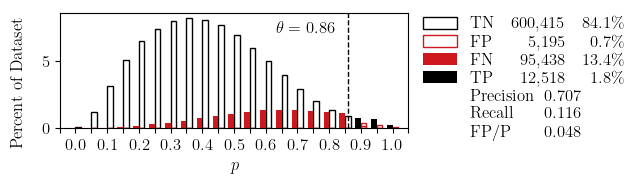


713566
713566
min =  0.0 , max =  1.0 , num_prec =  4
Plot_Prediction()
BRFC_alpha_0_5_Medium_Run_3
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
605610 107956 600224 5386 101249 6707

len(TP_vc) =  21
../../Dissertation_03_26_24/Figures/BRFC_alpha_0_5_Medium_Run_3_Pred_Wide_Threshold.pgf


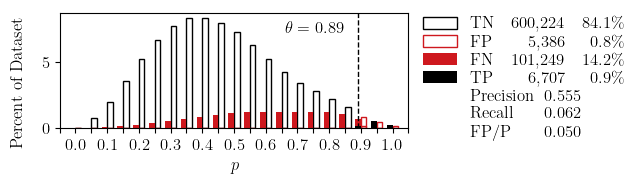


713566
713566
min =  0.0 , max =  1.0 , num_prec =  4
Plot_Prediction()
BRFC_alpha_0_5_Easy_Run_3
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
605610 107956 600213 5397 103675 4281

len(TP_vc) =  21
../../Dissertation_03_26_24/Figures/BRFC_alpha_0_5_Easy_Run_3_Pred_Wide_Threshold.pgf


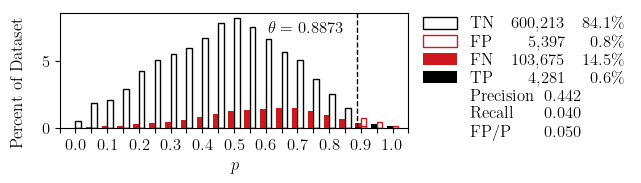


713566
713566
min =  0.0018518057 , max =  0.9854259 , num_prec =  4
Plot_Prediction()
KBFC_alpha_0_5_gamma_2_0_Hard_Run_3
len(C), len(D), len(TN), len(FP), len(FN), len(TP)
605610 107956 600220 5390 97192 10764

len(TP_vc) =  21
../../Dissertation_03_26_24/Figures/KBFC_alpha_0_5_gamma_2_0_Hard_Run_3_Pred_Wide_Threshold.pgf


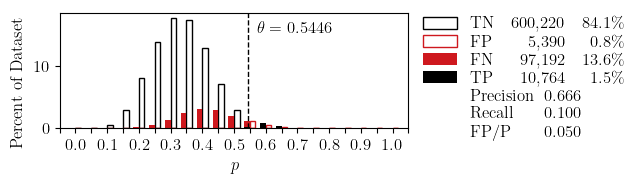

In [38]:
for filename, threshold in [
    ['BRFC_alpha_0_5_Hard_Run_3', 0.86],
    ['BRFC_alpha_0_5_Medium_Run_3', 0.89],
    ['BRFC_alpha_0_5_Easy_Run_3', 0.8873],
    ['KBFC_alpha_0_5_gamma_2_0_Hard_Run_3', 0.5446],
]:
    Dissertation_Illustrations(filename, threshold)